# Recreating the previous meta-analysis

i.e. '[Understanding coralline algal responses to ocean acidification: Meta-analysis and synthesis](https://onlinelibrary.wiley.com/doi/full/10.1111/gcb.15899)' (Cornwall et al., 2022)

The R code used for the analysis (Meta-analysis Figure 5-6.Rmd), along with the two .csv datasets (juvenile_raw_data(in).csv, juvenile_raw_data(in).csv) were provided by Ben Harvey.

The following is a translation of the original R code into Python to compare and contrast with our new analysis.


In [1]:
### autoreload
%reload_ext autoreload
%autoreload 2

### imports
import pandas as pd
import numpy as np
from calcification import config, analysis
import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages

from tqdm import tqdm

# R
metafor = rpackages.importr("metafor")
base = rpackages.importr("base")
mumin = rpackages.importr("MuMIn")
pandas2ri.activate()    # ensure pandas to R conversion is activated
# custom
from calcification import utils, plotting, analysis

effects_fp = config.tmp_data_dir / "effect_sizes.csv"
effects = pd.read_csv(effects_fp)

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [2]:
### load climatology for predictions and contextualising
ph_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = utils.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

effects_df_mi = effects.set_index(['doi', 'location', 'longitude', 'latitude'])
effects_clim_df = effects_df_mi.join(merged_clim_df_mi, how='inner')

# length of complete effects_df - number of rows not matching up with sst_df, multiplied by number of sst rows per effect row
expected_num = (len(effects_df_mi) - len(set(effects_df_mi.index).difference(set(merged_clim_df_mi.index)))) * 12
actual_num = len(effects_clim_df)

print(f"Expected number of rows: {expected_num}")
print(f"{expected_num-actual_num}-row anomaly between climatology and effects dataframes")

Expected number of rows: 14712
4188-row anomaly between climatology and effects dataframes


/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:773: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/calcification/utils.py:773: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(


In [3]:
print('Number of unique locations in ', effects_clim_df.index.nunique(), " CONCERNING") # CHECK

Number of unique locations in  116  CONCERNING


In [ ]:
# compute effects df and align with climatology # TODO: check this whole pipeline


# def run_analysis_end_to_end(
#     effects_df: pd.DataFrame,
#     effect_type: str,
#     treatment: str = None,
#     formula: str = None,
# ) -> None:
#     # run model
#     model = analysis.run_metafor_model(
#         df=effects_df,
#         effect_type=effect_type,
#         treatment=treatment,
#         formula=formula,
#     )
#     # 

# def generate_plots(predictions_df: pd.DataFrame, model_var: str, model: object, run_key: str=None, regplot_kwargs: dict = None, temporal_kwargs: dict = None, spatial_kwargs: dict = None) -> None:
#     # regression
#     regplot_fig, regplot_ax = plotting.meta_regplot(model, **regplot_kwargs)

#     ### prediction plots
#     # temporal effects
#     temporal_fig, temporal_ax = plotting.plot_global_timeseries(predictions_df, **temporal_kwargs)
#     # spatial effects
#     spatial_fig, spatial_ax = plotting.plot_spatial_effect_distribution(predictions_df, **spatial_kwargs)

    
generate_plots(predictions_shortform, model_var='hedges_g', model)

In [242]:
### preprocessing
# add ID column
effects["ID"] = effects.index
working_df = effects.copy()


ph_model, ph_model_summary, ph_df = analysis.run_metafor_model(
    working_df,
    effect_type='hedges_g',
    # treatment='phtot',
    necessary_vars=['core_grouping'],
)

temp_model, temp_model_summary, temp_df = analysis.run_metafor_model(
    working_df,
    effect_type='hedges_g',
    treatment='temp',
    necessary_vars=['core_grouping'],
)


----- PROCESSING SUMMARY -----
Treatment:  None
Total samples in input data:  1284
Total samples of relevant investigation:  1284
Dropped due to NaN values in required columns: 0
Final sample count: 1284 (0 rows dropped)

Removed 15 outliers (from 1284 samples) based on Cook's distance threshold of 0.08
Using formula hedges_g ~ factor(core_grouping) - 1

Running metafor model...
Model fitting complete.

----- PROCESSING SUMMARY -----
Treatment:  temp
Total samples in input data:  1284
Total samples of relevant investigation:  444
Dropped due to NaN values in required columns: 2
Final sample count: 442 (842 rows dropped)

Removed 5 outliers (from 442 samples) based on Cook's distance threshold of 0.17
Using formula hedges_g ~ delta_t + factor(core_grouping) - 1

Running metafor model...
Model fitting complete.


In [230]:
sst_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=temp_model,
    df=effects_clim_df,
    scenario_var='sst'
))
sst_preds = sst_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
sst_preds_shortform = sst_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
sst_preds_shortform.columns = ['_'.join(col).strip() for col in sst_preds_shortform.columns.values]
sst_preds_shortform.reset_index(inplace=True)
# sst_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)

ph_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=ph_model,
    df=effects_clim_df,
    scenario_var='ph'
))
ph_preds = ph_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
ph_preds_shortform = ph_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
ph_preds_shortform.columns = ['_'.join(col).strip() for col in ph_preds_shortform.columns.values]
ph_preds_shortform.reset_index(inplace=True)
# ph_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)
ph_preds_shortform['variable'] = 'ph'
sst_preds_shortform['variable'] = 'sst'

predictions_shortform = pd.concat([sst_preds_shortform, ph_preds_shortform], axis=0)


Generating batched predictions for sst:   0%|          | 0/116 [00:00<?, ?it/s]

Generating batched predictions for ph:   0%|          | 0/116 [00:00<?, ?it/s]

## Timeseries plots

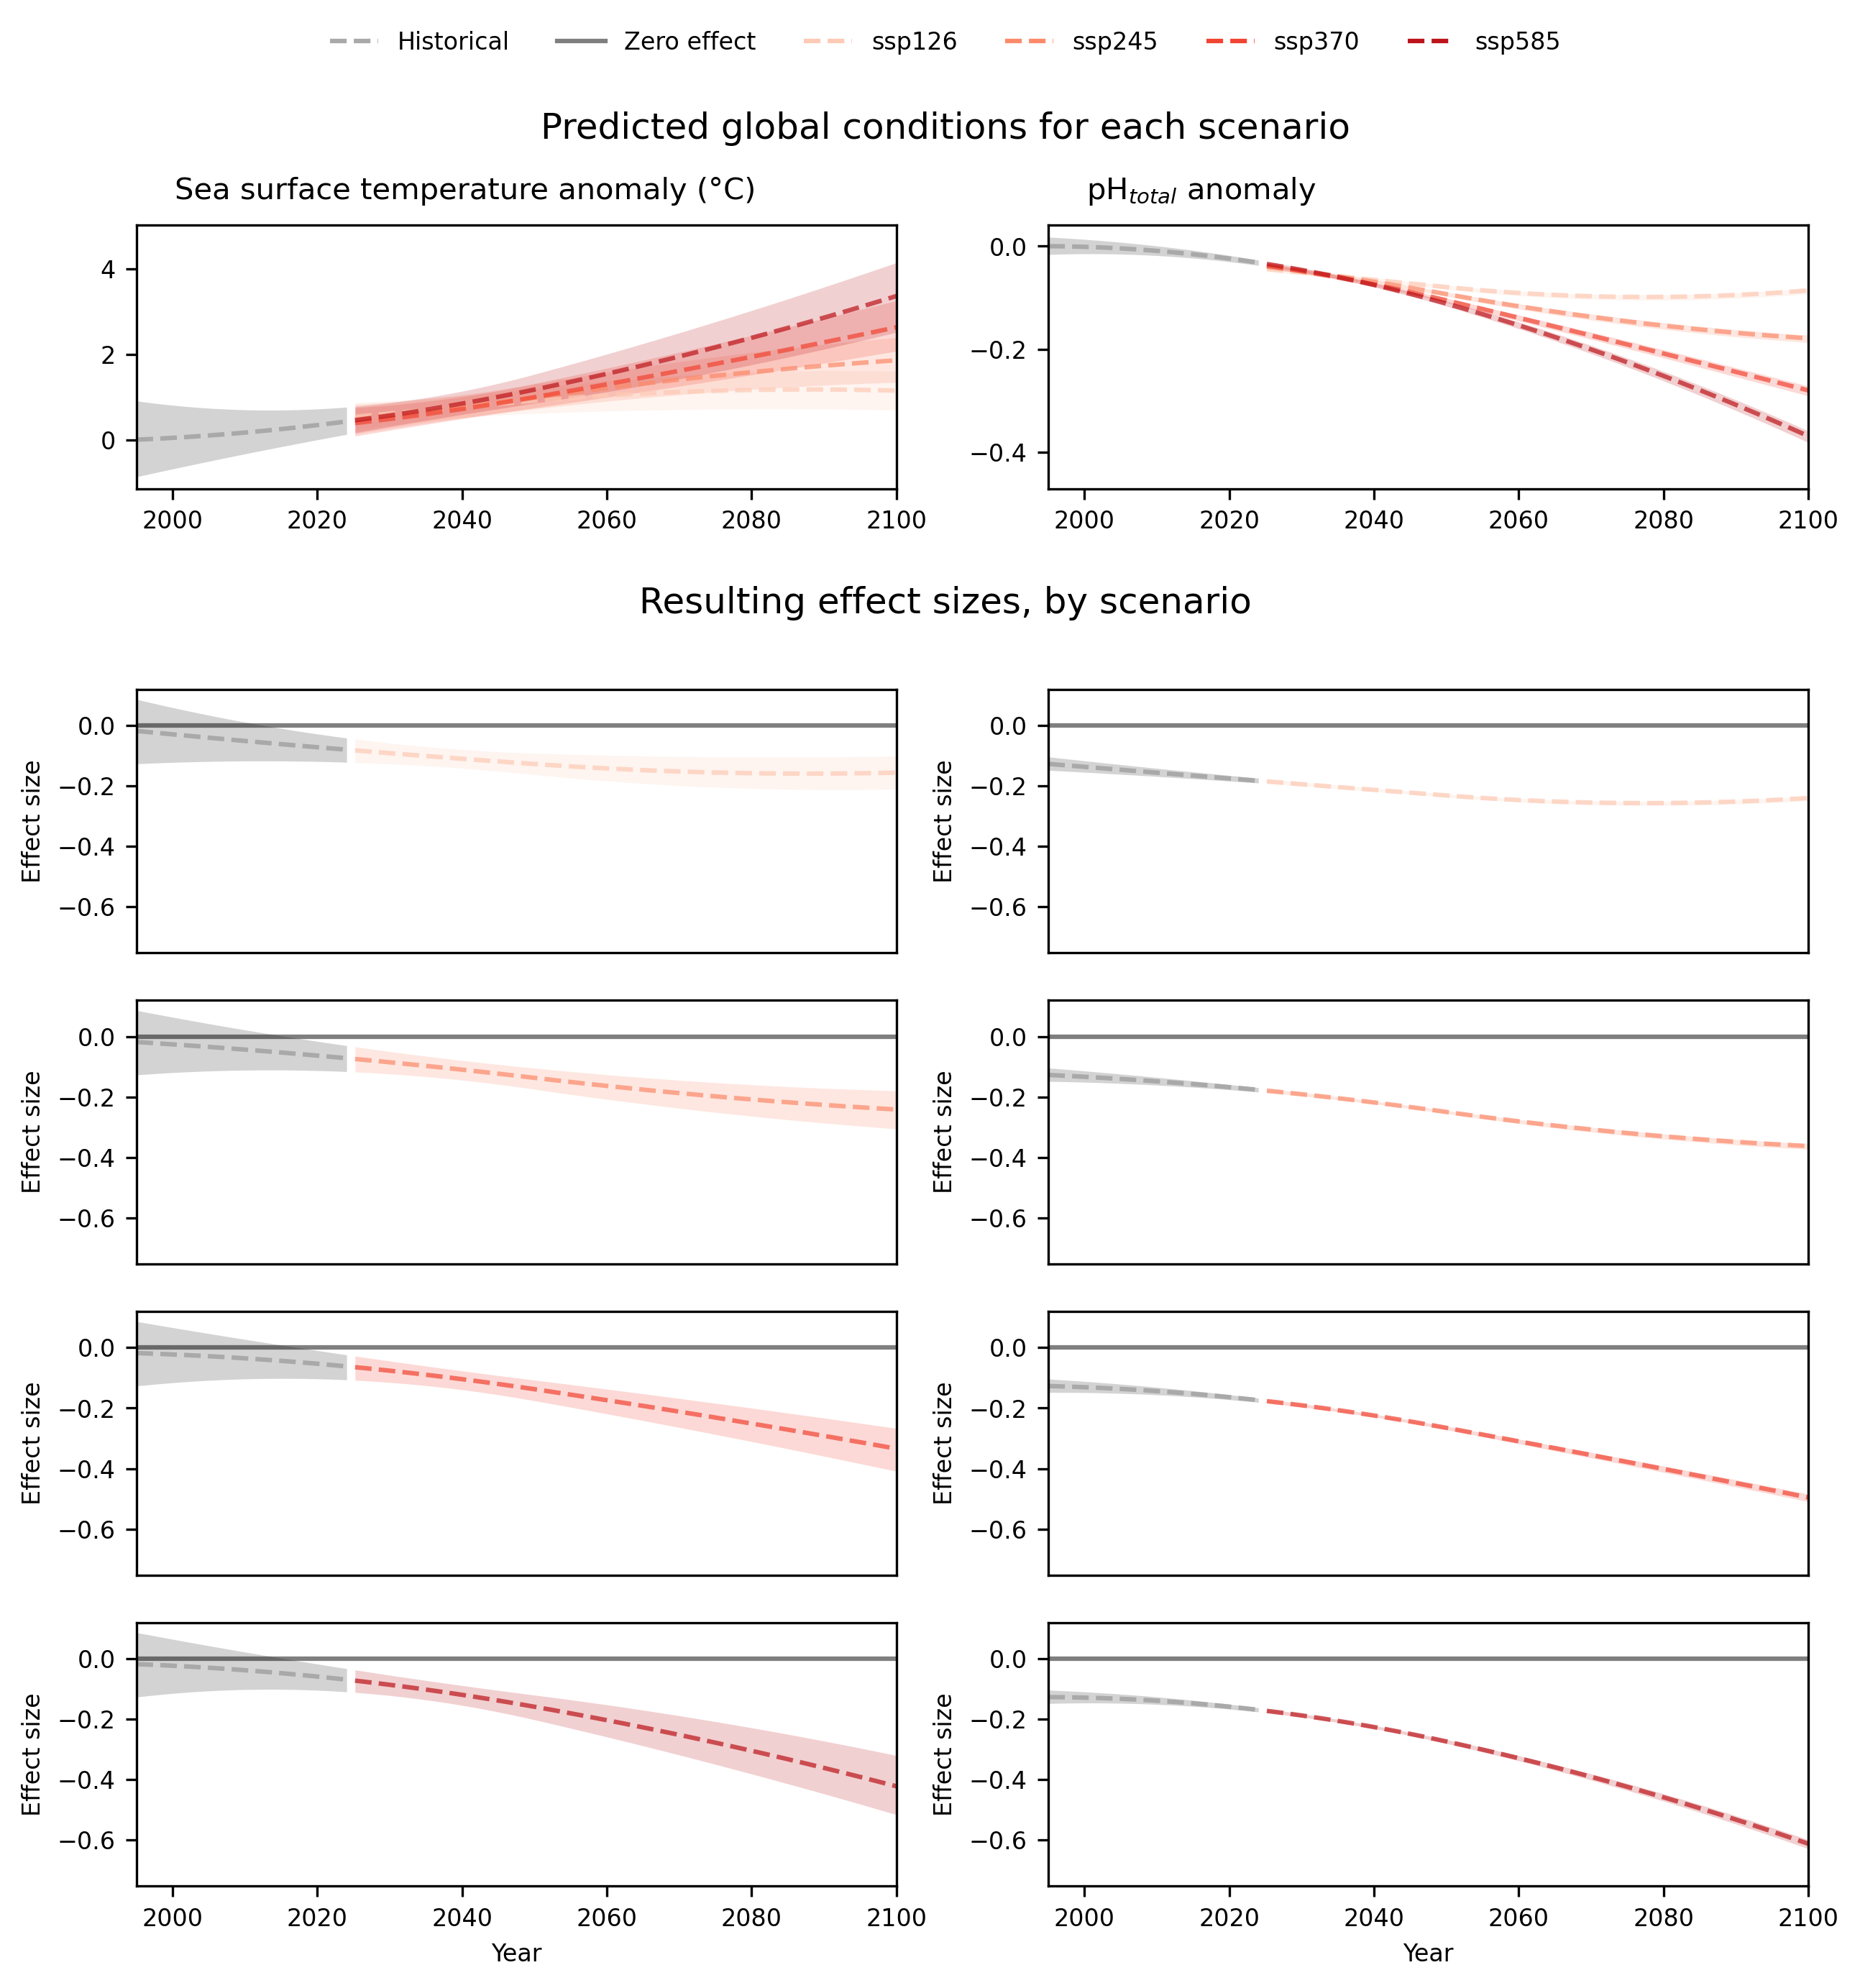

Saving figure to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures
Figure saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures/global_timeseries_test2025-04-08--22-39-30.png


In [272]:
ts_fig,_ = plotting.plot_global_timeseries(predictions_shortform, plot_vars=['sst', 'ph'], figsize=(10, 10), dpi=300)
plotting.save_fig(
    fig=ts_fig,
    fig_name='global_timeseries',
    run_key='test'
)

## Spatial plots

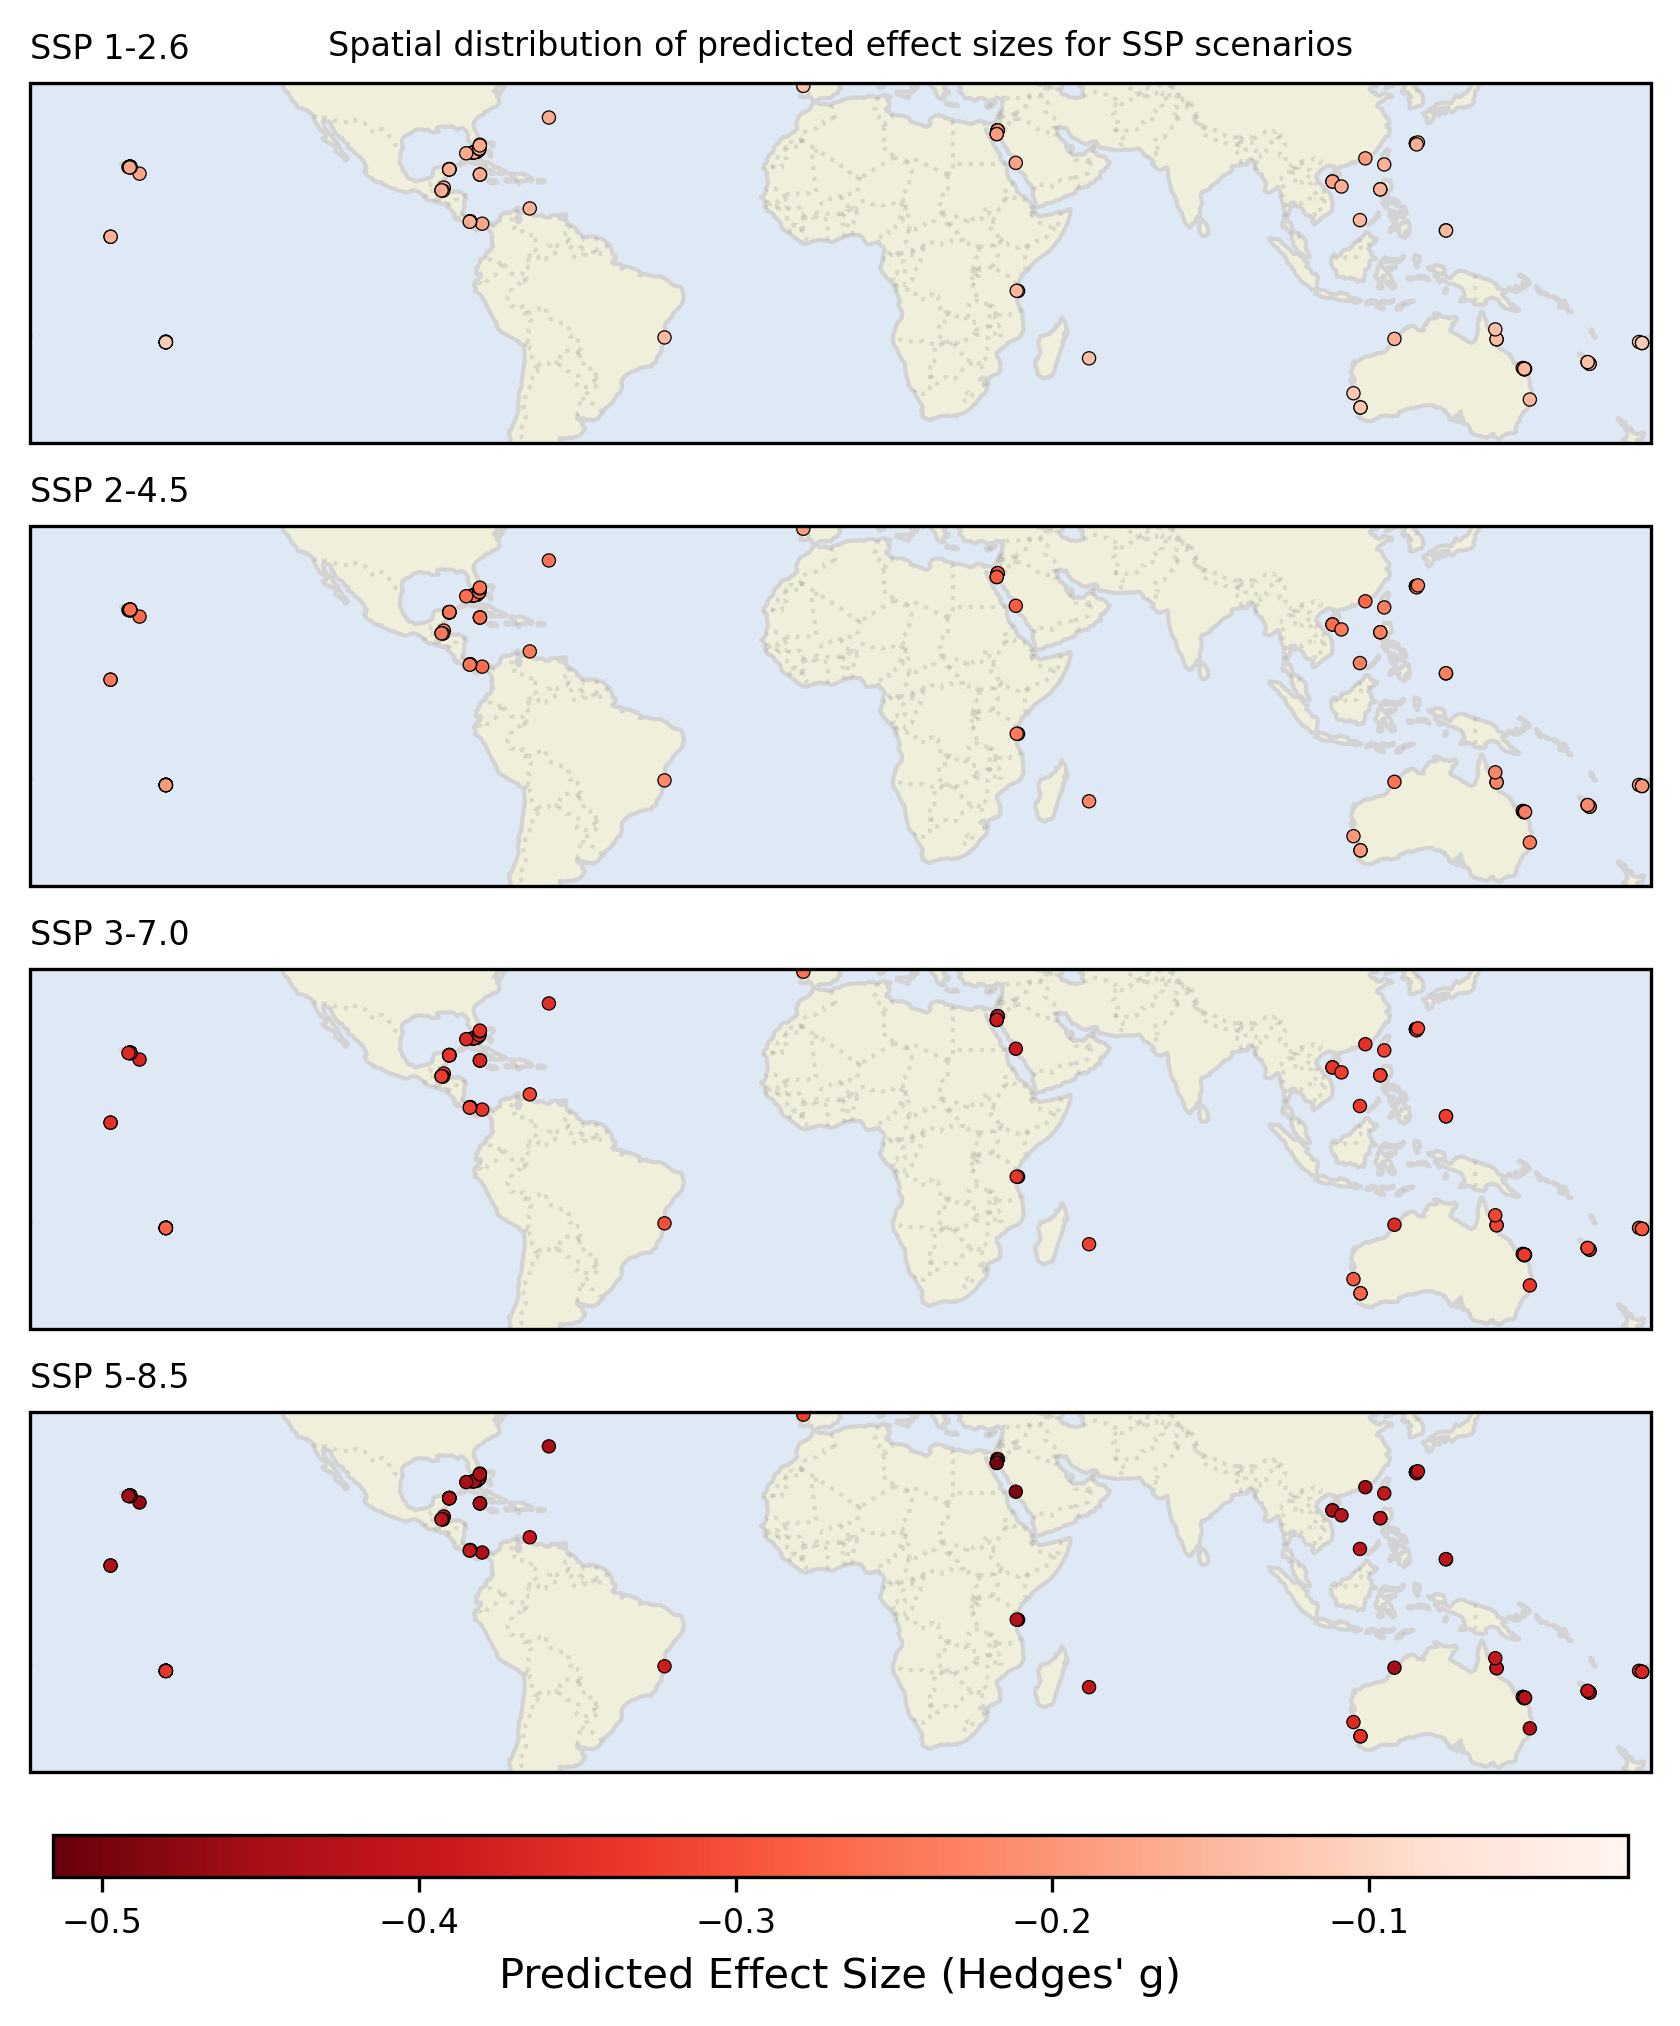

Saving figure to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures
Figure saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures/spatial_effect_distribution_sst_test2025-04-08--22-39-24.png


In [270]:
spatial_fig_sst,_ = plotting.plot_spatial_effect_distribution(sst_predictions_df, time_frame=2100, figsize=(7, 7), dpi=300)
plotting.save_fig(
    fig=spatial_fig_sst,
    fig_name='spatial_effect_distribution_sst',
    run_key='test'
)

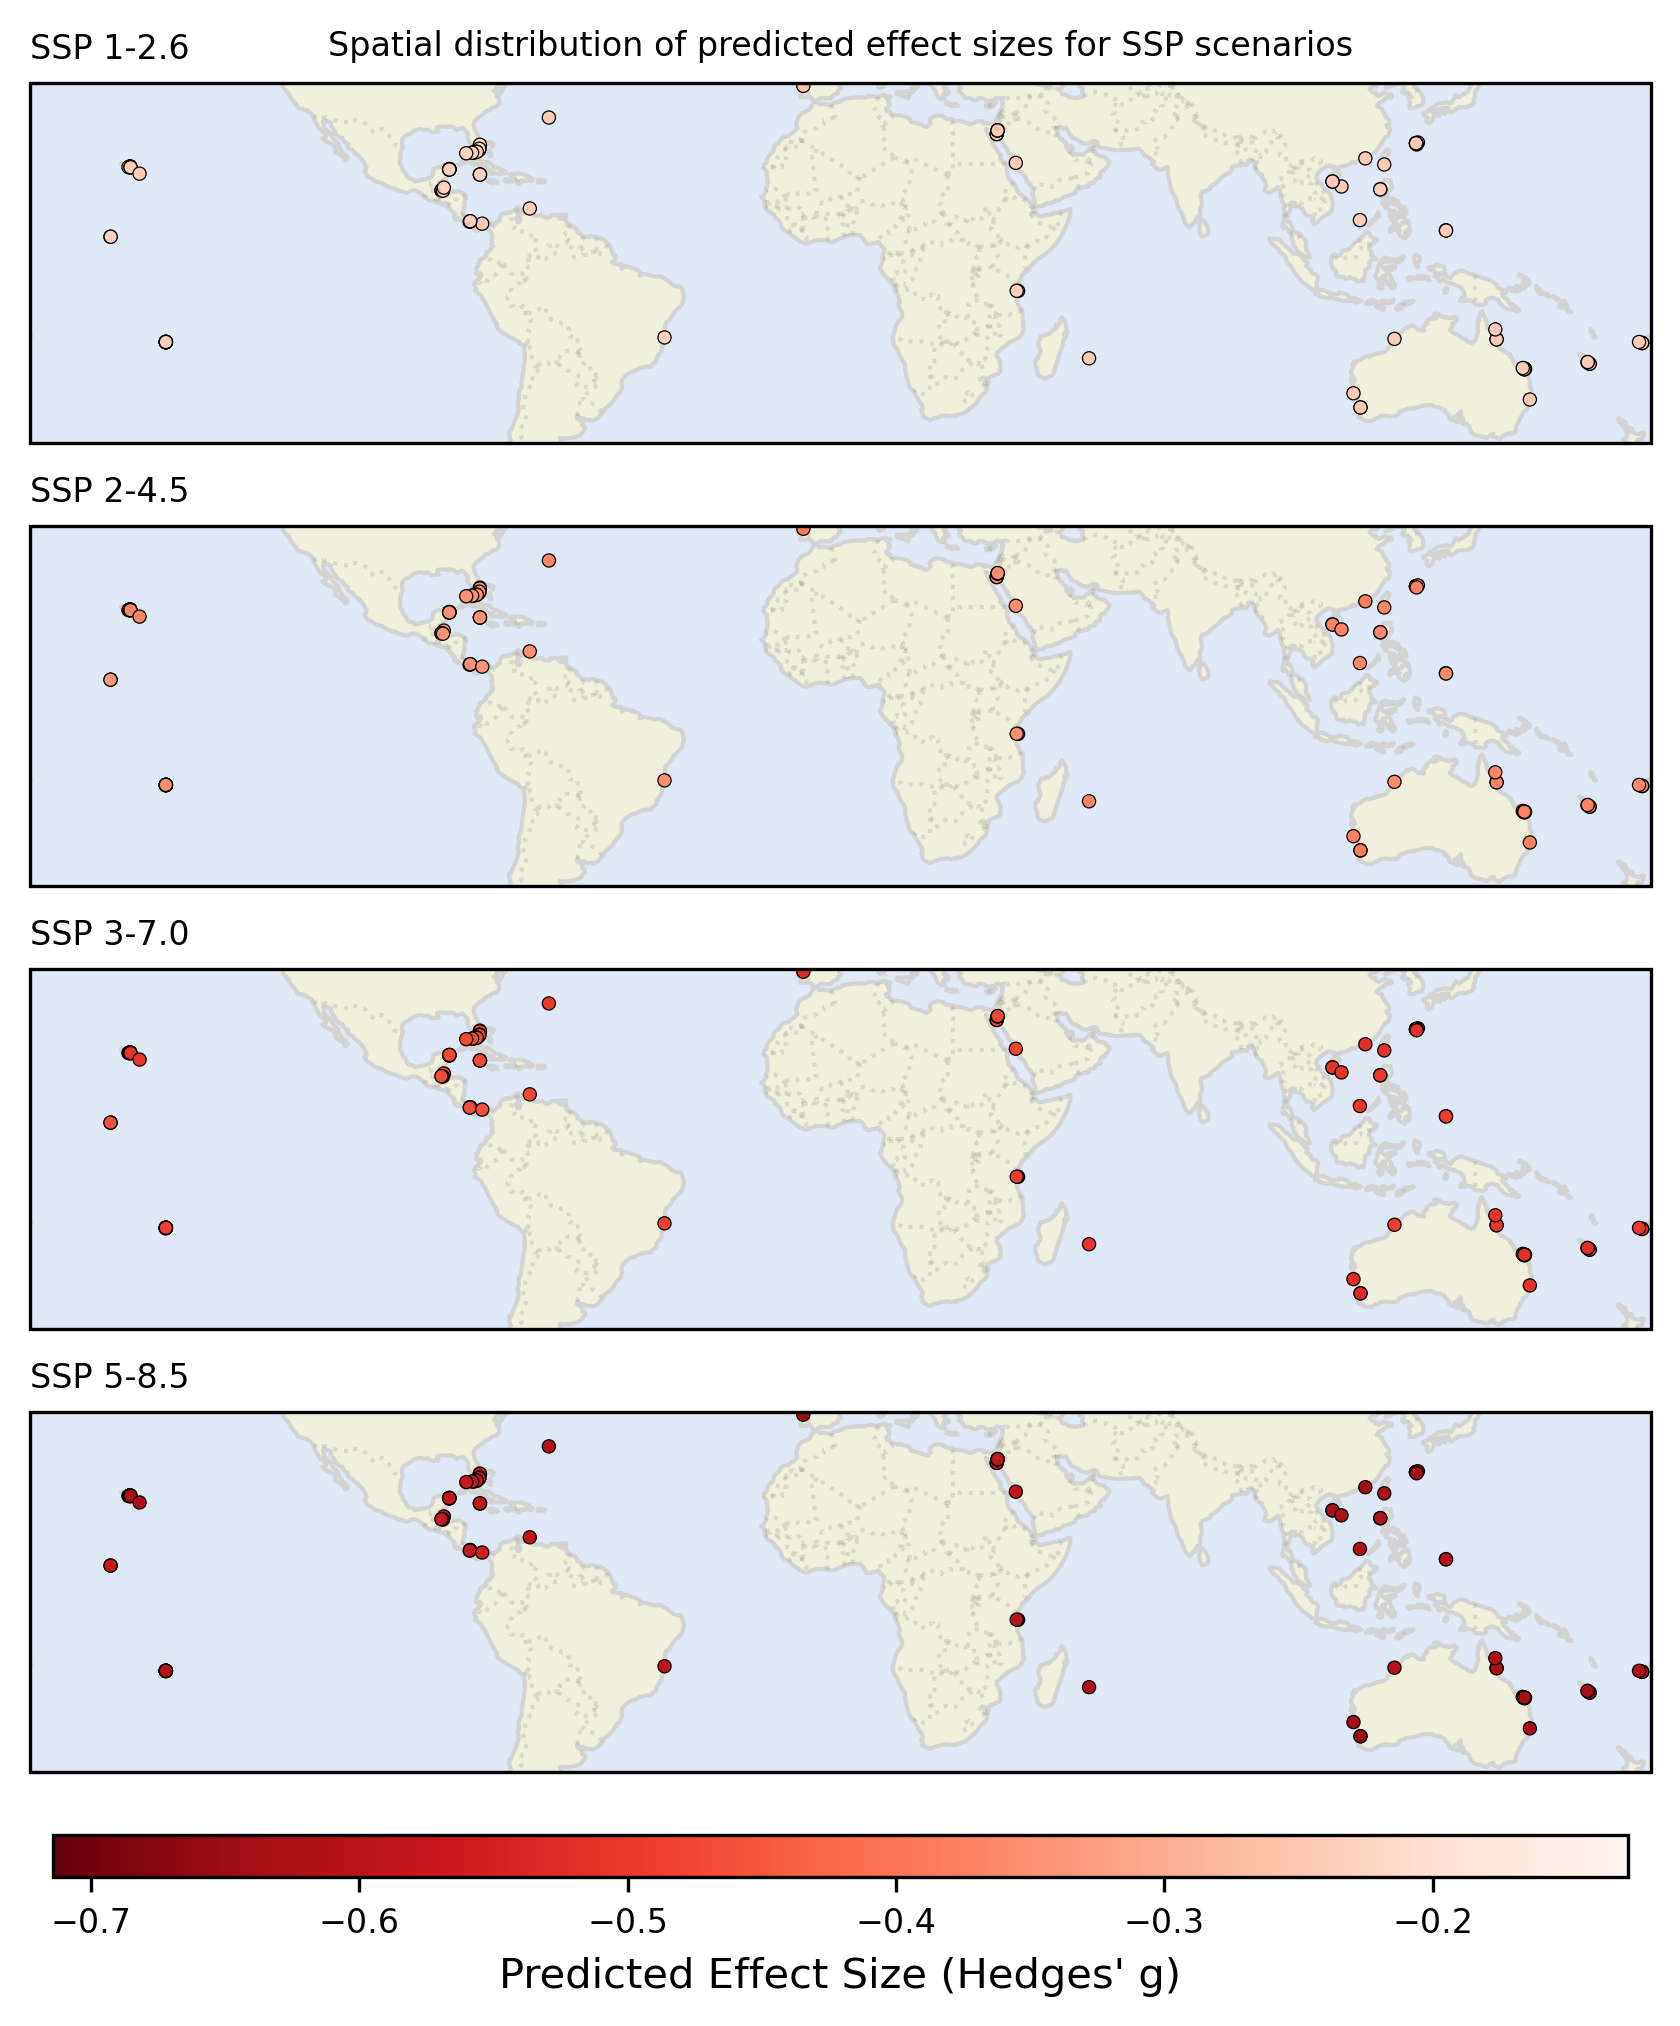

Saving figure to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures
Figure saved to /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/figures/spatial_effect_distribution_ph_test2025-04-08--22-39-26.png


In [271]:
spatial_fig_ph, _ = plotting.plot_spatial_effect_distribution(ph_predictions_df, time_frame=2100, figsize=(7, 7), dpi=300)
plotting.save_fig(
    fig=spatial_fig,
    fig_name='spatial_effect_distribution_ph',
    run_key='test'
)

Removed 12 outliers (from 840 samples) based on Cook's distance threshold of 0.14


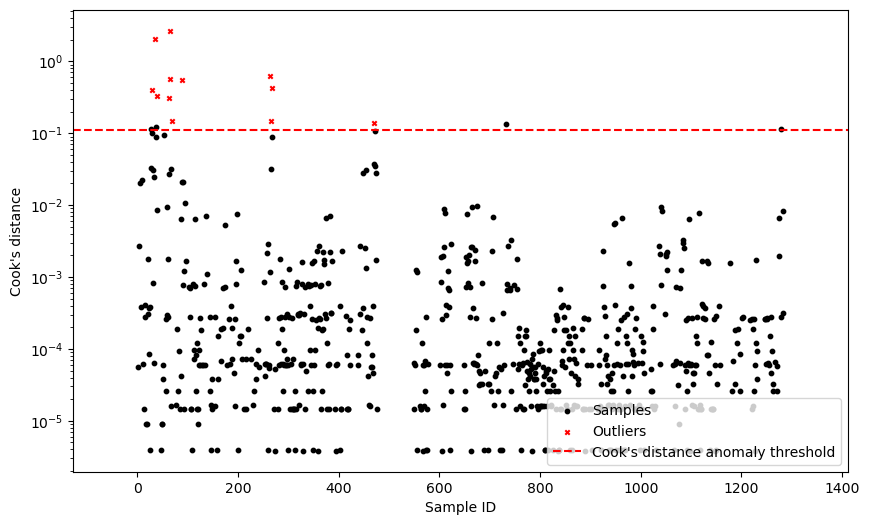

In [41]:
### visualise cooks distance
import matplotlib.pyplot as plt
import seaborn as sns

cooks_threshold = analysis.calc_cooks_threshold(working_df["hedges_g"], nparams=3)
data_no_outliers, outliers = remove_cooks_outliers(data, 'hedges_g')

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_no_outliers.index, data_no_outliers["cooks_d"], s=10, color="black", label="Samples")
# plot outliers as red dots
ax.scatter(
    outliers.ID,
    outliers.cooks_d,
    color="red",
    marker="x",
    s=10, label="Outliers",
)

ax.hlines(
    cooks_threshold,
    xmin=-working_df.ID.max()*.1,
    xmax=working_df.ID.max()*1.1,
    color="red",
    linestyle="--",
    label="Cook's distance anomaly threshold",
)
ax.set_xlim(
    -working_df.ID.max() * 0.1,
    working_df.ID.max() * 1.1,
)
ax.set_xlabel("Sample ID")
ax.set_ylabel("Cook's distance")
ax.set_yscale("log")
ax.legend(loc='lower right');

## Training model based on MuMIn

Investigating the effect of core_groupings, families, T, pH, ecoregion


In [44]:
temp_df[['hedges_g', 'hedges_g_var', 'delta_t', 'temp', 'ecoregion', 'original_doi', 'ID']].isna().any()

hedges_g        False
hedges_g_var    False
delta_t         False
temp            False
ecoregion       False
original_doi    False
ID              False
dtype: bool

In [86]:
temp_df.to_csv(
    config.tmp_data_dir / "temp_df.csv",
    index=False
)

In [ ]:
effect_type = 'hedges_g'
x_var = 'delta_t'
# global_formula = f"{effect_type} ~ {x_var} + temp + phtot + factor(family) + factor(ecoregion) + factor(realm) + factor(core_grouping) - 1"
# global_formula = f"{effect_type} ~ {x_var} + temp + factor(ecoregion) - 1"
global_formula = f"{effect_type} ~ {x_var} + temp"
r_formula = ro.Formula(global_formula)

temp_formula, temp_df = analysis.preprocess_df_for_meta_model(working_df, treatment='temp', necessary_vars=['temp', 'delta_t'])
df_r = ro.pandas2ri.py2rpy(temp_df)

global_model = metafor.rma_mv(
    yi = ro.FloatVector(df_r.rx2(effect_type)),
    V = ro.FloatVector(df_r.rx2(f"{effect_type}_var")), 
    mods = r_formula,
    random = ro.Formula("~ 1 | original_doi/ID"),
    data=df_r,
)

import os
# os.environ['LC_ALL'] = 'C'  # explicitly set locale to C (simplest)
os.environ['LC_ALL'] = 'en_US.UTF-8'  # set locale to UTF-8
ro.r.assign("global_model", global_model)

# Set up parallel processing cluster
n_cores = 16
ro.r(f"""
# set up for MuMIn
eval(metafor:::.MuMIn)
# Create cluster
clu <- parallel::makeCluster({n_cores})
# Load required packages on each worker
parallel::clusterEvalQ(clu, library(metafor))
parallel::clusterEvalQ(clu, library(MuMIn))

# Export the global model and other necessary objects to the cluster
parallel::clusterExport(clu, c("global_model"))

# # Run dredge
dredge_result <- MuMIn::dredge(global_model, cluster=clu)

# # Stop the cluster
parallel::stopCluster(clu)
""")

# """)
# ignore warnings (setting up LC_COLLATE failed, using "C")
# import warnings
# warnings.filterwarnings("ignore", category=rpy2.rinterface.RRuntimeWarning)

dredge_result = ro.r("dredge_result")
dredge_df = pandas2ri.rpy2py(dredge_result)
dredge_df = pd.DataFrame(dredge_df)
# # save to csv
# # dredge_df.to_csv(config.tmp_data_dir / "dredge_results.csv", index=False)
# # view result
dredge_df


----- PROCESSING SUMMARY -----
Total samples in input data:  1284
Total samples of relevant investigation:  444
Dropped due to NaN values in required columns: 2
Final sample count: 442 (842 rows dropped)

Removed 5 outliers (from 442 samples) based on Cook's distance threshold of 0.19


R[write to console]: Fixed term is "(Intercept)"



,(Intercept),delta_t,temp,df,logLik,AICc,delta,weight
3,1,NaN,NaN,5,-649.061924,1308.263058,0.000000,9.759244e-01
2,1,NaN,NaN,4,-653.787452,1315.667497,7.404439,2.407480e-02
1,1,NaN,NaN,4,-664.124565,1336.341723,28.078664,7.802104e-07
0,1,NaN,NaN,3,-670.211836,1346.479099,38.216040,4.908044e-09


In [71]:
ro.r("""
# Function to extract coefficients from models
get_model_coefficients <- function(ms_object) {
  coef_list <- lapply(1:nrow(ms_object), function(i) {
    model_i <- get.models(ms_object, i)[[1]]
    coefs <- coef(model_i)
    coef_df <- data.frame(
      model = i,
      variable = names(coefs),
      coefficient = unname(coefs),
      stringsAsFactors = FALSE
    )
    return(coef_df)
  })
  do.call(rbind, coef_list)
}

# Extract all coefficients
all_coefs <- get_model_coefficients(dredge_result)
write.csv(all_coefs, "model_coefficients.csv")
""")


R[write to console]: In addition: 
R[write to console]: There were 16 warnings (use warnings() to see them)
R[write to console]: 



In [79]:
ro.r("""
# Function to check if a variable is included in a model
is_variable_in_model <- function(model, variable) {
  # Get formula terms
  terms_obj <- terms(model)
  term_labels <- attr(terms_obj, "term.labels")
  
  # Check if variable is in terms
  return(variable %in% term_labels)
}

# Create a new data frame to hold results
model_table <- data.frame(
  model_id = seq_len(nrow(dredge_result)),
  df = dredge_result$df,
  logLik = dredge_result$logLik,
  AICc = dredge_result$AICc,
  delta = dredge_result$delta,
  weight = dredge_result$weight
)

# Get the actual models
models_list <- get.models(dredge_result, subset = TRUE)

# Add columns for each predictor
predictors <- c("delta_t", "temp")
for (pred in predictors) {
  model_table[[pred]] <- sapply(models_list, function(model) {
    if (is_variable_in_model(model, pred)) {
      return("INCLUDED")
    } else {
      return("EXCLUDED")
    }
  })
}

# Save to CSV
write.csv(model_table, "model_inclusion_table.csv", row.names = FALSE)

# Now get the actual coefficients
coef_table <- data.frame()
for (i in seq_along(models_list)) {
  model <- models_list[[i]]
  coefs <- coef(model)
  model_coefs <- data.frame(
    model_id = i,
    parameter = names(coefs),
    estimate = as.numeric(coefs),
    row.names = NULL
  )
  coef_table <- rbind(coef_table, model_coefs)
}

# Save coefficients
write.csv(coef_table, "model_coefficients.csv", row.names = FALSE)
""")

R[write to console]: Error in x$terms %||% attr(x, "terms") %||% stop("no terms component nor attribute") : 
  no terms component nor attribute



RRuntimeError: Error in x$terms %||% attr(x, "terms") %||% stop("no terms component nor attribute") : 
  no terms component nor attribute


In [81]:
import pandas as pd
import numpy as np

def clean_dredge_output(df):
    cleaned_df = df.copy()
    
    # Identify meta columns
    info_cols = ['df', 'logLik', 'AICc', 'delta', 'weight']
    
    # Coefficient columns (everything else)
    coef_cols = [col for col in df.columns if col not in info_cols]

    # Format coefficient columns
    for col in coef_cols:
        cleaned_df[col] = cleaned_df[col].apply(
            lambda x: f"{x:.5f}" if pd.notnull(x) else ""
        )
    
    # Round meta columns sensibly
    cleaned_df['logLik'] = cleaned_df['logLik'].round(3)
    cleaned_df['AICc'] = cleaned_df['AICc'].round(1)
    cleaned_df['delta'] = cleaned_df['delta'].round(2)
    cleaned_df['weight'] = cleaned_df['weight'].round(3)

    # Optional: add model number
    cleaned_df.insert(0, "Model", range(1, len(cleaned_df) + 1))

    return cleaned_df

cleaned_table = clean_dredge_output(dredge_df)
print(cleaned_table.head(10).to_string(index=False))


 Model (Intercept) delta_t temp  df   logLik   AICc  delta  weight
     1     1.00000                5 -649.062 1308.3   0.00   0.976
     2     1.00000                4 -653.787 1315.7   7.40   0.024
     3     1.00000                4 -664.125 1336.3  28.08   0.000
     4     1.00000                3 -670.212 1346.5  38.22   0.000


In [82]:
ro.r("""
get_dredge_summary <- function(dredge_obj) {
  result_list <- list()
  
  for (i in seq_len(nrow(dredge_obj))) {
    model_i <- get.models(dredge_obj, subset=i)[[1]]
    coefs <- summary(model_i)$beta
    vars_in_model <- names(coefs)
    all_vars <- names(dredge_obj)
    
    row <- setNames(as.list(rep(NA, length(all_vars))), all_vars)
    
    for (v in all_vars) {
      if (v %in% vars_in_model) {
        row[[v]] <- coefs[v]
      } else {
        row[[v]] <- NA
      }
    }
    
    # Add model fit metrics
    row$df <- dredge_obj$df[i]
    row$logLik <- dredge_obj$logLik[i]
    row$AICc <- dredge_obj$AICc[i]
    row$delta <- dredge_obj$delta[i]
    row$weight <- dredge_obj$weight[i]
    
    result_list[[i]] <- row
  }
  
  summary_df <- do.call(rbind, lapply(result_list, as.data.frame))
  rownames(summary_df) <- NULL
  return(summary_df)
}

dredge_clean_df <- get_dredge_summary(dredge_result)
""")


In [85]:
dredge_clean_df = ro.r("dredge_clean_df")
dredge_clean_df = ro.conversion.rpy2py(dredge_clean_df)
dredge_clean_df

,X.Intercept.,delta_t,temp,df,logLik,AICc,delta,weight
1,-2147483648,-2147483648,-2147483648,5,-649.061924,1308.263058,0.000000,9.759244e-01
2,-2147483648,-2147483648,-2147483648,4,-653.787452,1315.667497,7.404439,2.407480e-02
3,-2147483648,-2147483648,-2147483648,4,-664.124565,1336.341723,28.078664,7.802104e-07
4,-2147483648,-2147483648,-2147483648,3,-670.211836,1346.479099,38.216040,4.908044e-09


In [76]:
ro.r("""
# Create a custom representation of the dredge results
custom_model_table <- as.data.frame(dredge_result)

# Function to process each cell
process_cell <- function(x) {
  if (is.na(x)) {
    return("NA")  # Variable not included in model
  } else if (is.nan(x)) {
    return("INCLUDED")  # Variable included but value not shown
  } else {
    return(as.character(x))  # Actual value
  }
}

# Process the predictor columns
predictors <- c("delta_t", "temp")
for (pred in predictors) {
  if (pred %in% names(custom_model_table)) {
    custom_model_table[[pred]] <- sapply(custom_model_table[[pred]], process_cell)
  }
}

# Save to CSV
write.csv(custom_model_table, "detailed_model_table.csv", row.names = TRUE)
""")

In [78]:
ro.r("""
# Extract actual coefficient values for each model
coef_table <- data.frame(Model = integer(), Predictor = character(), Value = numeric())

# For each model in the dredge results
for (i in 1:nrow(dredge_result)) {
  # Get the model
  model_i <- get.models(dredge_result, i)[[1]]
  
  # Extract coefficients
  coefs <- coef(model_i)
  
  # Add to the table
  for (j in 1:length(coefs)) {
    coef_table <- rbind(coef_table, data.frame(
      Model = i,
      Predictor = names(coefs)[j],
      Value = as.numeric(coefs[j])
    ))
  }
}

# Save coefficients to CSV
write.csv(coef_table, "model_coefficients.csv", row.names = FALSE)
""")

In [75]:
ro.r("""
# Save the dredge result directly to CSV
write.csv(as.data.frame(dredge_result), "dredge_result.csv", row.names = TRUE)
""")

In [73]:
model_coefficients = pd.read_csv("model_coefficients.csv")
model_coefficients

,Unnamed: 0,model,variable,coefficient
0,1,1,intrcpt,6.910880
1,2,1,delta_t,0.124963
2,3,1,temp,-0.258764
3,4,2,intrcpt,4.383506
4,5,2,temp,-0.160593
5,6,3,intrcpt,-0.103834
6,7,3,delta_t,-0.095320
7,8,4,intrcpt,-0.399570


In [66]:
ro.r('str(dredge_result)')

Classes ‘model.selection’ and 'data.frame':	4 obs. of  7 variables:
 $ delta_t: num  NaN NaN NA NA
 $ temp   : num  NaN NA NaN NA
 $ df     : int  4 3 3 3
 $ logLik : num  -664 -666 -668 -670
 $ AICc   : num  1335 1338 1341 1346
 $ delta  : num  0 2.37 5.95 11.29
 $ weight : 'model.weights' num  0.7349 0.225 0.0375 0.0026
 - attr(*, "model.calls")=List of 4
  ..$ 3: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 1: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 2: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
  ..$ 0: language (function (yi, V, W, mods, data, slab, subset, random, struct = "CS", intercept = TRUE,      method = "REML", tes| __truncated__ ...
 - attr(*, "global")=List of 124
  .

In [68]:
# Convert to a standard R data frame first before bringing to Python
ro.r("""
# Convert to a standard data frame and handle any special formatting
dredge_df_r <- as.data.frame(dredge_result)
# If needed, you can also get more information about variable importance
importance_df_r <- as.data.frame(sw(dredge_result))
""")

# Now convert the standard data frame to Python
dredge_df = pandas2ri.rpy2py(ro.r("dredge_df_r"))

In [69]:
dredge_df

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [65]:
pandas2ri.activate()
pandas2ri.rpy2py(ro.r('dredge_result'))


,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [46]:
pandas2ri.rpy2py(ro.r("dredge_df_r"))

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-663.548351,1335.189295,0.000000,0.734875
1,NaN,NaN,3,-665.750432,1337.556292,2.366997,0.225023
2,NaN,NaN,3,-667.542187,1341.139802,5.950507,0.037504
0,NaN,NaN,3,-670.211836,1346.479099,11.289804,0.002598


In [97]:
# Convert to a more standard format first
ro.r("dredge_df <- as.data.frame(dredge_result)")
dredge_df = pandas2ri.rpy2py(ro.r("dredge_df"))
dredge_df

,delta_t,temp,df,logLik,AICc,delta,weight
3,NaN,NaN,4,-473.094361,954.325707,0.000000,0.551830
1,NaN,NaN,3,-474.723942,955.529796,1.204088,0.302232
2,NaN,NaN,3,-475.732375,957.546661,3.220953,0.110251
0,NaN,NaN,3,-476.860369,959.802650,5.476942,0.035686


In [91]:
dredge_result

delta_t,temp,df,logLik,AICc,delta,weight
...,...,...,...,...,...,...


## Predictions

- pH (T constant)
- T (pH constant)
- variable pH and T

In [110]:
# first, test with average values
model_matrix = ro.r('model.matrix')(model)
col_means = ro.r('colMeans')(model_matrix)
prediction = ro.r('predict')(
    model, 
    newmods=col_means, 
    digits=2
)
print(prediction)


  pred   se ci.lb ci.ub pi.lb pi.ub 
 -0.39 0.16 -0.71 -0.08 -2.62  1.84 




(0, 10)


(-0.6, 0.0)

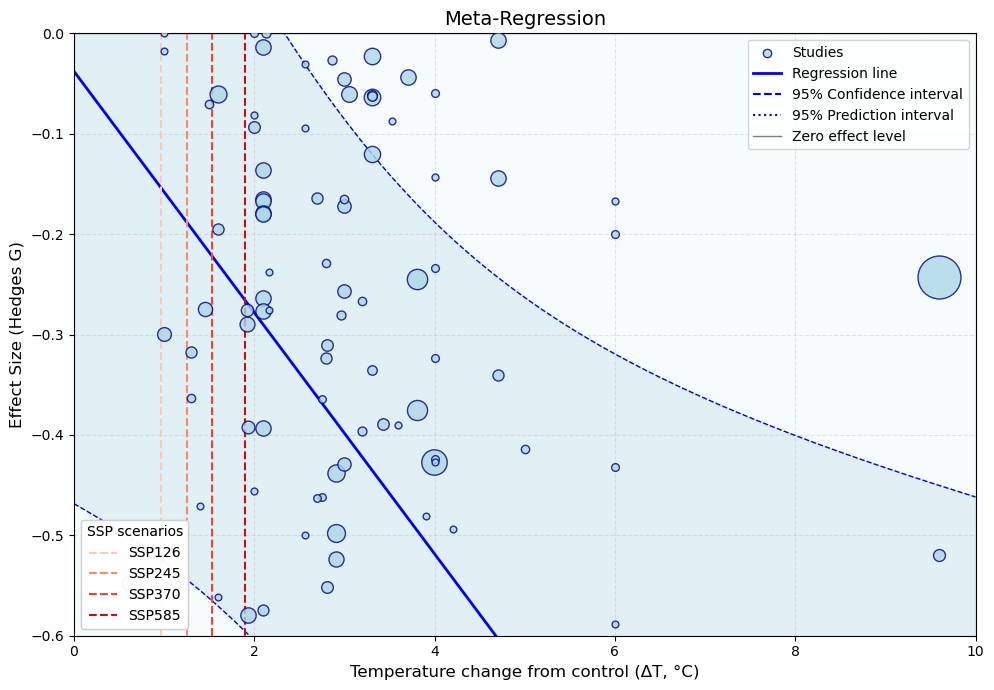

In [165]:
fig, ax = plotting.meta_regplot(model, mod_pos=0,
                      point_size="seinv", 
                      point_color='navy',
                      point_fill='lightblue',
                      ci=True,
                      refline=0,
                      shade=True,
                      ci_color='lightblue',
                      title="Meta-Regression",
                      xlim = (0, 10),
                      predlim = (0, 10),
                      xlab = "pH change from control (ΔpH)" if x_var == "delta_ph" else "Temperature change from control (ΔT, °C)",
                      ylab=f"Effect Size ({effect_type.replace('_', ' ').title()})",)

### annotate with future climatology
df = effects_clim_df
variable = x_var

scenarios = df['scenario'].unique()
colors = sns.color_palette("Reds", len(scenarios))
scenario_var = 'ph' if 'ph' in variable else 'sst'
scenario_lines = []
for i, scenario in enumerate(scenarios):
    scenario_df = df[df['scenario'] == scenario]
    line = ax.vlines(
        x=scenario_df[f'mean_{scenario_var}_20y_anomaly_ensemble'].mean(), 
        ymin=working_df[effect_type].min()*1.1, 
        ymax=working_df[effect_type].max()*1.1, 
        color=colors[i],
        linestyle='--', 
        label=scenario.upper(), 
        # zorder=10
    )
    scenario_lines.append(line)
ax.set_ylim(
    working_df[effect_type].min()*1.1, 
    working_df[effect_type].max()*1.1
)

# get existing legend
legend1 = ax.get_legend()
legend2 = plt.legend(
    handles=scenario_lines, 
    title='SSP scenarios', 
    loc='lower left', 
)
# add the new legend to the graph along with the original
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_ylim(-0.6,0)

In [ ]:
ro.r('colMeans')(model_matrix)[:]

array([2.95456345, 7.82616208, 0.15824916, 0.69023569, 0.11784512,
       0.03367003])

R[write to console]: Error in predict.rma(list(b = c(-0.12016246685229, -0.305203915900049,  : 
  Dimensions of 'newmods' (1) do not the match dimensions of the model (6).



RRuntimeError: Error in predict.rma(list(b = c(-0.12016246685229, -0.305203915900049,  : 
  Dimensions of 'newmods' (1) do not the match dimensions of the model (6).


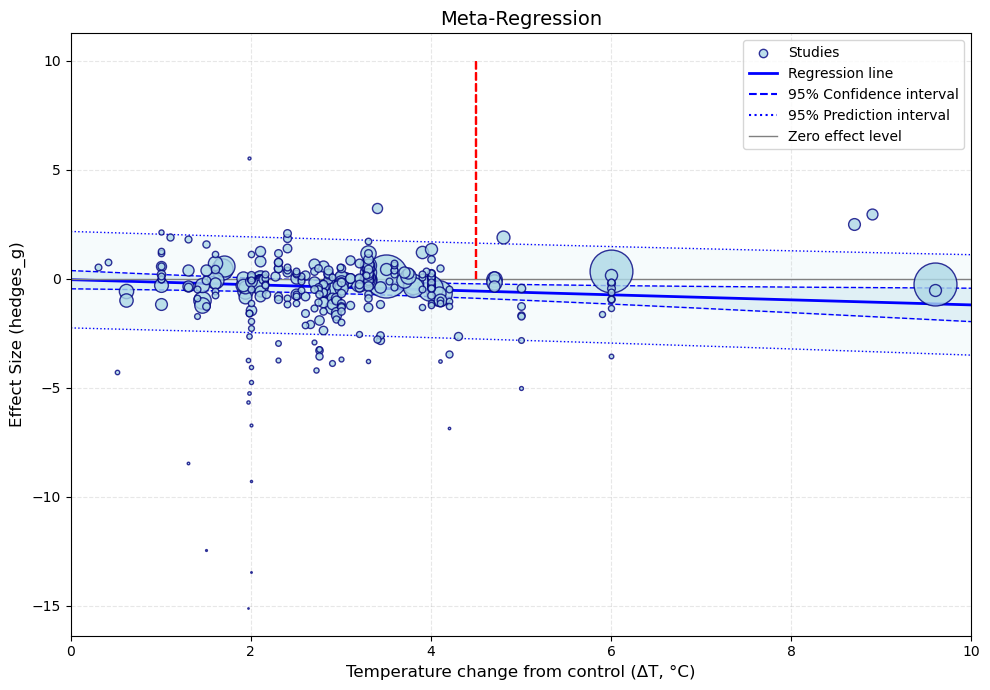

In [ ]:
# now adjust pH keeping temp constant

# Deprecated